In [ ]:
#stage 01 (libraries)
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
#stage 1

In [3]:
# Exploring data set
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [4]:
#training image dataset
dataset_size = len(dataset)
dataset_size

50000

In [5]:
#test dataset size
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [6]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
#shape of an image from 
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog


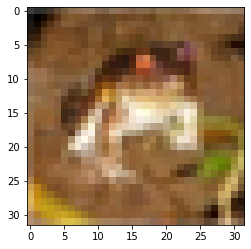

In [8]:
#RGB color image . let us look at a sample of color image
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [9]:
#Number of images belonging to each class
img_count_per_class = {label: 0 for label in classes}
for img, label in dataset:
    img_count_per_class[classes[label]] += 1
    
img_count_per_class

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

In [ ]:
#Stage 02

In [10]:
#validation set size 10000 ie 20% 
torch.manual_seed(43)
val_size = 10000
train_size = len(dataset) - val_size

In [ ]:
#creating training & validation set using random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

In [12]:
#Creating data loader to load data in batches
batch_size=128

In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
#visualize data using make_grid helper function from torch vision
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('on')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
#Stage 03

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.3f}, val_acc: {:.3f}".format(epoch, result['val_loss'], result['val_acc']))

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
torch.cuda.is_available()

True

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Epochs VS Loss');

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Epochs VS Accuracy');

In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)



In [ ]:
#Stage 04

In [26]:
input_size = 3*32*32
output_size = 10

In [27]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1650)
        # hidden layers
        self.linear2 = nn.Linear(1650, 512)
        self.linear3 = nn.Linear(512, 138)
        # output layer
        self.linear4 = nn.Linear(138, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear4(out)
        # Apply activation function
        out = F.relu(out)
        return out

In [28]:
model = to_device(CIFAR10Model(), device)

In [29]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10807675123214722, 'val_loss': 2.303123712539673}]

In [30]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 2.1317, val_acc: 0.2327
Epoch [1], val_loss: 1.8361, val_acc: 0.3397
Epoch [2], val_loss: 1.7678, val_acc: 0.3780
Epoch [3], val_loss: 1.7620, val_acc: 0.3749
Epoch [4], val_loss: 1.7019, val_acc: 0.3927
Epoch [5], val_loss: 1.6408, val_acc: 0.4220
Epoch [6], val_loss: 1.5945, val_acc: 0.4385
Epoch [7], val_loss: 1.5828, val_acc: 0.4318
Epoch [8], val_loss: 1.5858, val_acc: 0.4392
Epoch [9], val_loss: 1.5552, val_acc: 0.4412


In [31]:
history += fit(8, 0.005, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4387, val_acc: 0.4912
Epoch [1], val_loss: 1.4322, val_acc: 0.4891
Epoch [2], val_loss: 1.4285, val_acc: 0.4916
Epoch [3], val_loss: 1.4249, val_acc: 0.4954
Epoch [4], val_loss: 1.4227, val_acc: 0.4978
Epoch [5], val_loss: 1.4141, val_acc: 0.5000
Epoch [6], val_loss: 1.4160, val_acc: 0.5033
Epoch [7], val_loss: 1.4102, val_acc: 0.4991


In [32]:
history += fit(7, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4154, val_acc: 0.5058
Epoch [1], val_loss: 1.4030, val_acc: 0.5021
Epoch [2], val_loss: 1.4012, val_acc: 0.5055
Epoch [3], val_loss: 1.4279, val_acc: 0.5003
Epoch [4], val_loss: 1.4089, val_acc: 0.4990
Epoch [5], val_loss: 1.4157, val_acc: 0.4953
Epoch [6], val_loss: 1.3844, val_acc: 0.5124


In [33]:
history += fit(4, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3614, val_acc: 0.5233
Epoch [1], val_loss: 1.3607, val_acc: 0.5219
Epoch [2], val_loss: 1.3599, val_acc: 0.5212
Epoch [3], val_loss: 1.3596, val_acc: 0.5244


In [34]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7733, val_acc: 0.3834
Epoch [1], val_loss: 1.5780, val_acc: 0.4326
Epoch [2], val_loss: 1.6129, val_acc: 0.4199
Epoch [3], val_loss: 1.5422, val_acc: 0.4522
Epoch [4], val_loss: 1.6422, val_acc: 0.4329


In [35]:
history += fit(10, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4750, val_acc: 0.4815
Epoch [1], val_loss: 1.4353, val_acc: 0.4935
Epoch [2], val_loss: 1.4192, val_acc: 0.4989
Epoch [3], val_loss: 1.4105, val_acc: 0.5018
Epoch [4], val_loss: 1.4049, val_acc: 0.5016
Epoch [5], val_loss: 1.4008, val_acc: 0.5049
Epoch [6], val_loss: 1.3978, val_acc: 0.5055
Epoch [7], val_loss: 1.3953, val_acc: 0.5073
Epoch [8], val_loss: 1.3933, val_acc: 0.5086
Epoch [9], val_loss: 1.3916, val_acc: 0.5094


In [36]:
#since 0.001 gives best accuracy,
history += fit(25, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3825, val_acc: 0.5182
Epoch [1], val_loss: 1.3774, val_acc: 0.5174
Epoch [2], val_loss: 1.3739, val_acc: 0.5205
Epoch [3], val_loss: 1.3711, val_acc: 0.5211
Epoch [4], val_loss: 1.3686, val_acc: 0.5207
Epoch [5], val_loss: 1.3667, val_acc: 0.5221
Epoch [6], val_loss: 1.3656, val_acc: 0.5213
Epoch [7], val_loss: 1.3639, val_acc: 0.5219
Epoch [8], val_loss: 1.3631, val_acc: 0.5232
Epoch [9], val_loss: 1.3615, val_acc: 0.5227
Epoch [10], val_loss: 1.3608, val_acc: 0.5217
Epoch [11], val_loss: 1.3595, val_acc: 0.5218
Epoch [12], val_loss: 1.3587, val_acc: 0.5238
Epoch [13], val_loss: 1.3583, val_acc: 0.5236
Epoch [14], val_loss: 1.3569, val_acc: 0.5262
Epoch [15], val_loss: 1.3558, val_acc: 0.5262
Epoch [16], val_loss: 1.3562, val_acc: 0.5235
Epoch [17], val_loss: 1.3552, val_acc: 0.5276
Epoch [18], val_loss: 1.3540, val_acc: 0.5256
Epoch [19], val_loss: 1.3532, val_acc: 0.5256
Epoch [20], val_loss: 1.3535, val_acc: 0.5245
Epoch [21], val_loss: 1.3517, val_acc: 0.526

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
#Saturation point
history += fit(11, 0.001, model, train_loader, val_loader)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [39]:
evaluate(model, test_loader)

{'val_acc': 0.54296875, 'val_loss': 1.3001505136489868}

In [40]:
arch =  '4 layers (1650,512,138,10)'

In [41]:
lrs = [0.5,0.01,0.05,0.001,0.1]

In [42]:
epochs = [5,7,8,10,4, 25]

In [43]:
test_acc =  0.54
test_loss = 1.30

In [ ]:
fig = plt.figure()
s = fig.add_subplot(111)
s.bar([70, 80], [50, 51], width=5)
s.set_xlim(0, 90)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Model Accuracy')
fig.savefig('t.png')

In [44]:
torch.save(model.state_dict(), 'cifar10-feedforward.pth')